# ML MODEL CREATION

Importing the necessary libraries

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

Importing the Data

In [16]:
df = pd.read_excel("ML_Data.xlsx")

Splitting training and testing Data

In [17]:
# Splitting the dataset into the features and the target variable
X = df.drop('depression_status', axis=1)  # Features
y = df['depression_status']  # Target variable

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Training the models

In [19]:
# Set random seed for reproducibility
np.random.seed(42)


# Define the models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting Machines": GradientBoostingClassifier(),
    "SVM": SVC(kernel='rbf')
}


# Define the metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# Prepare cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# Evaluation function
def evaluate_model(model, X, y, cv, scoring):
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    return scores



# Run and evaluate models
results = {}
for name, model in models.items():
    results[name] = {}
    for score_name, scorer in scoring.items():
        result = evaluate_model(model, X_train, y_train, cv, scorer)
        results[name][score_name] = result.mean()

# Print the results
for model_name, scores in results.items():
    print(f"Results for {model_name}:")
    for score_name, score_value in scores.items():
        print(f"{score_name.capitalize()}: {score_value:.4f}")
    print()

Results for Logistic Regression:
Accuracy: 0.7258
Precision: 0.7058
Recall: 0.7702
F1: 0.7350

Results for Random Forest:
Accuracy: 0.8080
Precision: 0.8033
Recall: 0.7702
F1: 0.7981

Results for Gradient Boosting Machines:
Accuracy: 0.7734
Precision: 0.7831
Recall: 0.7635
F1: 0.7708

Results for SVM:
Accuracy: 0.7826
Precision: 0.7459
Recall: 0.8532
F1: 0.7948



Feature Selection

In [20]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    font = {'weight': 'bold', 'size': 12}
    #Define size of bar plot
    plt.figure(figsize=(30,30))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'Feature Importance', fontsize=30)
    xlabel=plt.xlabel('FEATURE IMPORTANCE')
    xlabel.set_size(20)
    ylabel=plt.ylabel('FEATURE NAMES')
    ylabel.set_size(20)
    

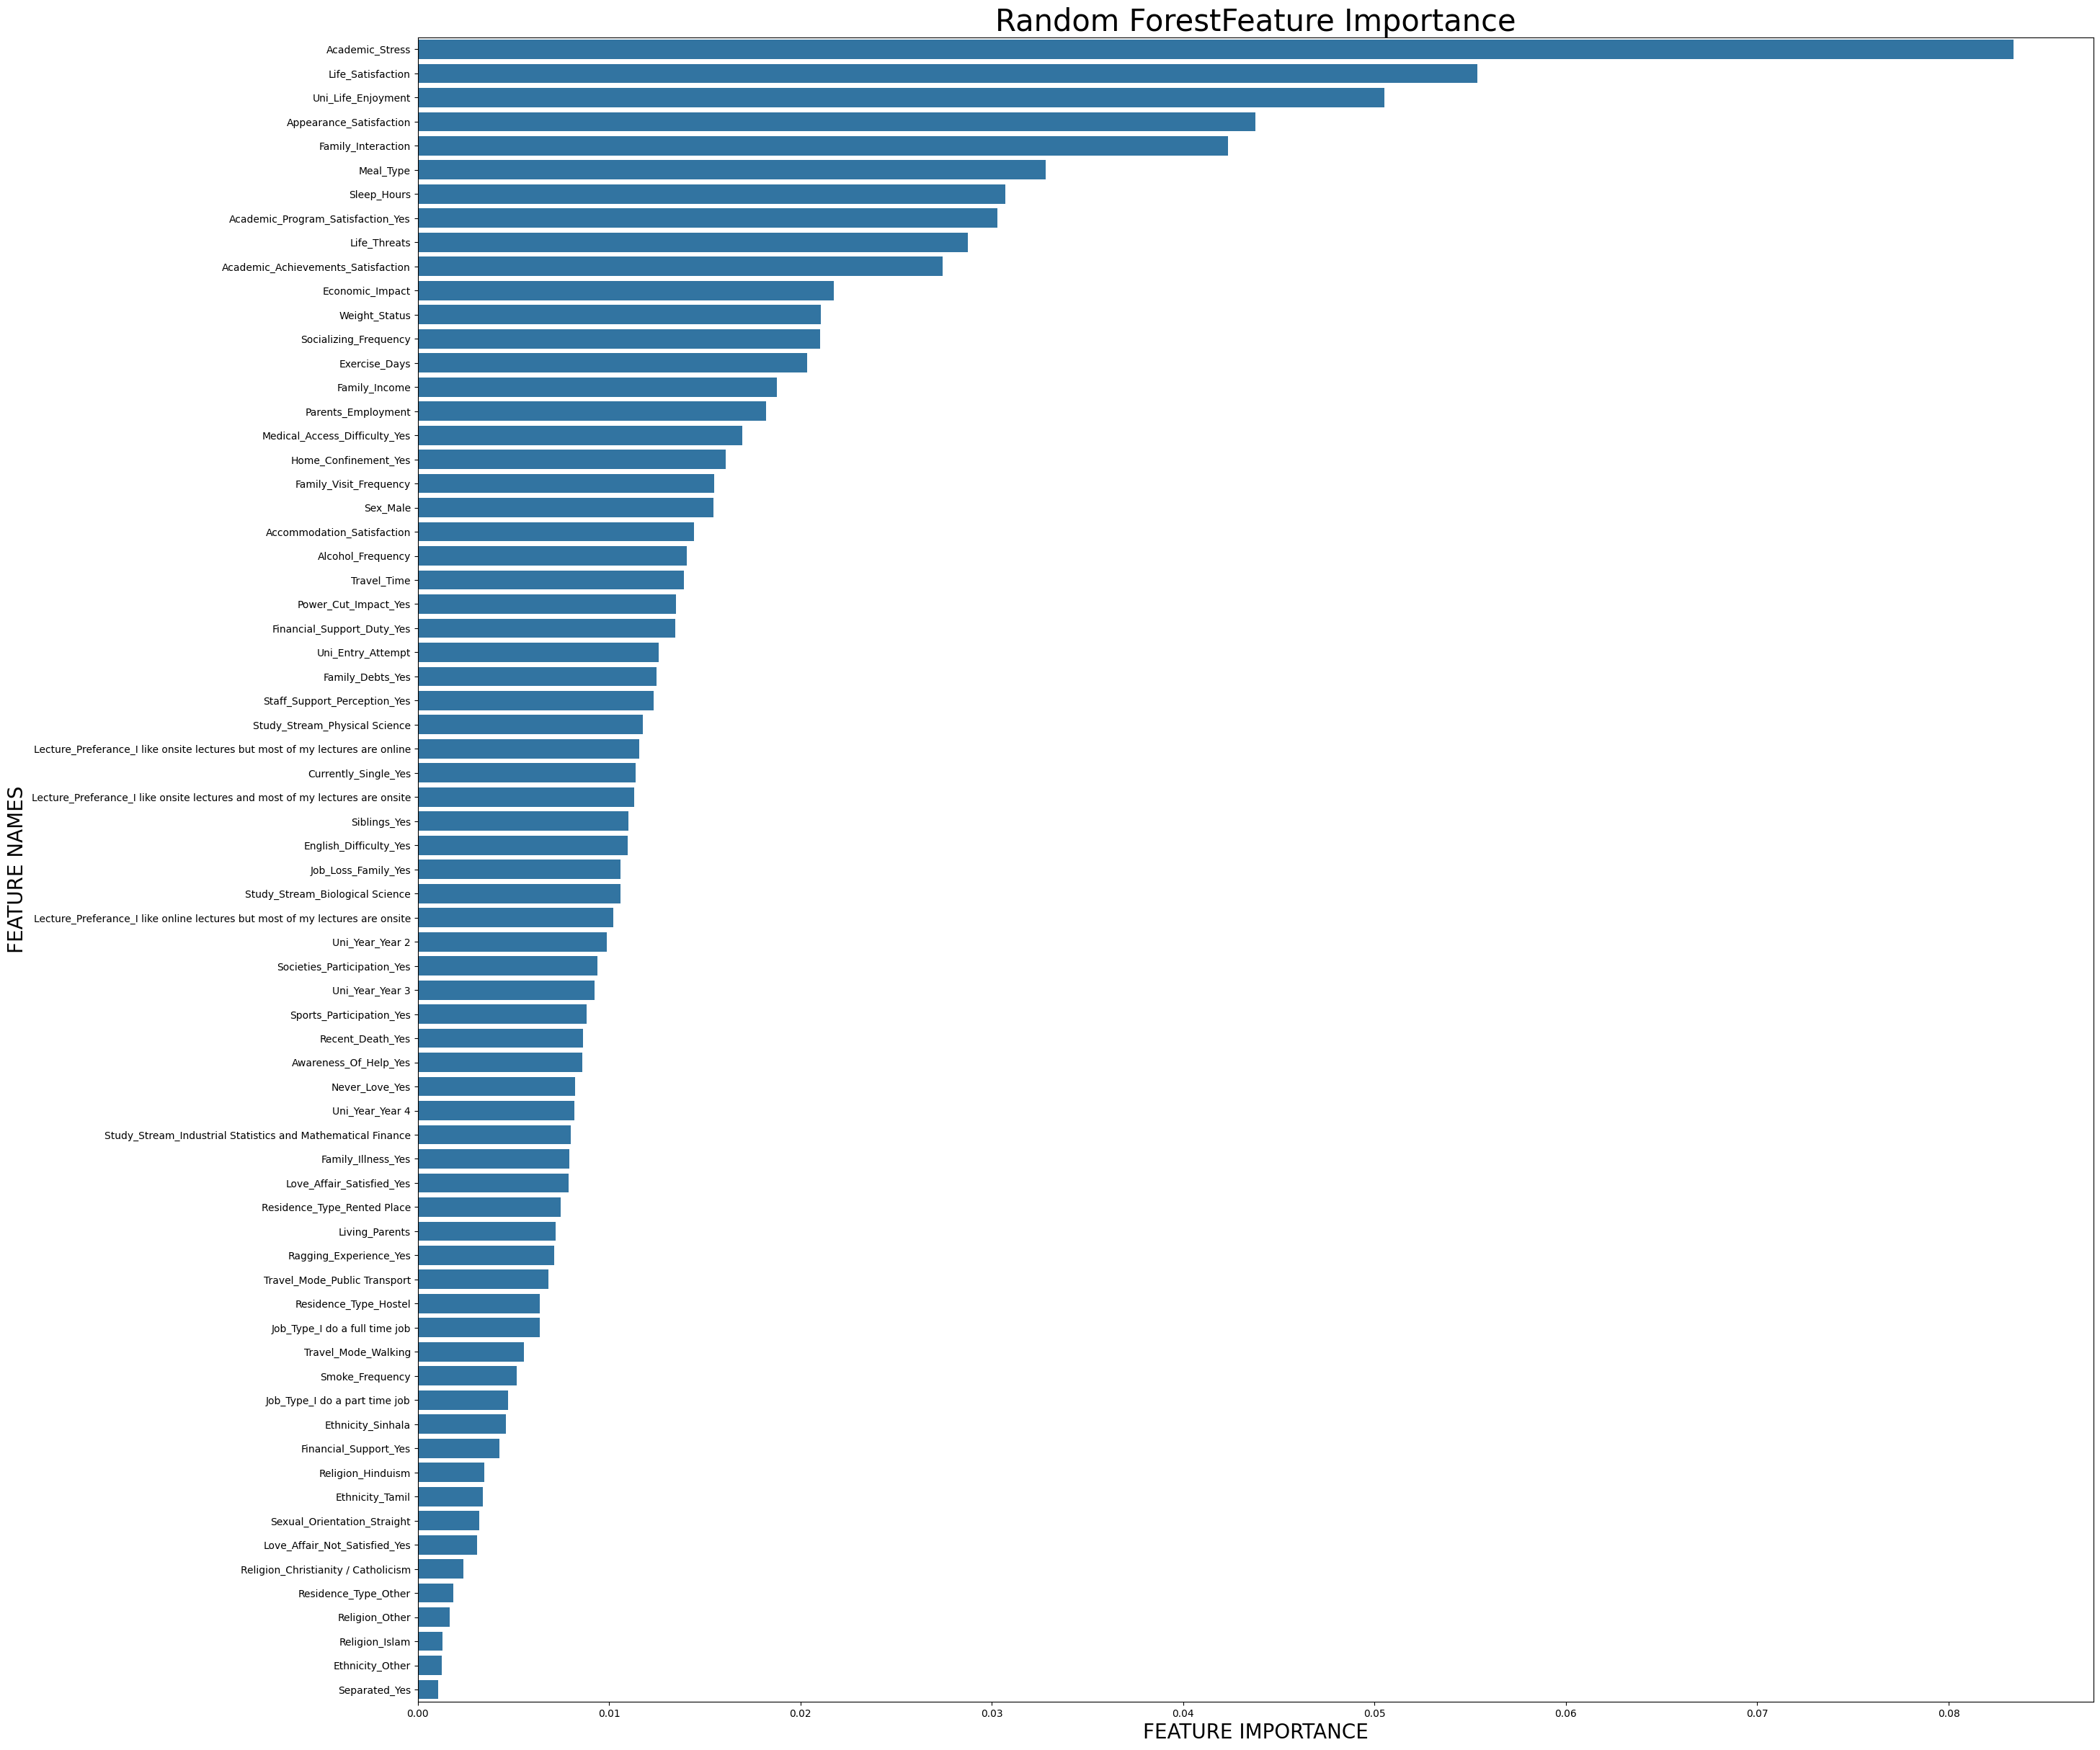

In [21]:
model=RandomForestClassifier(random_state=42)
model.fit(X_train,y_train)
plot_feature_importance(model.feature_importances_, X_train.columns,'Random Forest')

In [23]:
""""Let us now only keep 10 of the most important variables for moving further"""



# Create and train the Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Get feature importances from the model
importances = rf.feature_importances_

# Create a DataFrame to view feature names and their importance scores
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})

# Sort the DataFrame by importance in descending order
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Select the top 10 most important features
top_features = feature_importances['feature'].head(10).tolist()

# Filter x_train and x_test to keep only the top 10 features
x_train_selected = X_train[top_features]
x_test_selected = X_test[top_features]

# If you need to view or use the list of top features elsewhere:
print("Top 10 features selected by Random Forest:", top_features)


Top 10 features selected by Random Forest: ['Academic_Stress', 'Life_Satisfaction', 'Uni_Life_Enjoyment', 'Appearance_Satisfaction', 'Family_Interaction', 'Meal_Type', 'Sleep_Hours', 'Academic_Program_Satisfaction_Yes', 'Life_Threats', 'Academic_Achievements_Satisfaction']


Hyperparameter Tuning

In [26]:
# Define the model
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Setup the GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best estimator for further predictions
best_rf = grid_search.best_estimator_


Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.81


Evaluating the final model on train and test set

In [27]:
# Predict on the training set and test set
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# Define a function to calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1

# Calculate metrics for the training set
train_accuracy, train_precision, train_recall, train_f1 = calculate_metrics(y_train, y_train_pred)

# Calculate metrics for the test set
test_accuracy, test_precision, test_recall, test_f1 = calculate_metrics(y_test, y_test_pred)

# Print the results
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")

print("\nTest Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")


Training Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Test Metrics:
Accuracy: 0.8875
Precision: 0.9714
Recall: 0.8095
F1 Score: 0.8831
